# FermiPy Extended Source Example

Fermipy includes a module for fitting the extension of a detected source.
https://fermipy.readthedocs.io/en/latest/advanced/extension.html

You can find an example in the fermipy extra notebooks: https://github.com/fermiPy/fermipy-extra/blob/master/notebooks/ic443.ipynb

* First, we will fit the baseline catalog model for the region around HESS J1825-137 
* Then, we will delete the source associated with HESS J1825-137 from our model.
* We will add a point source and compare with the extended source
* We will test the added point source for extension by varying the size of a radial disk model and finding the radius that maximizes Delta Log Likelihood for the radial disk model as compared to the best-fit point source model.
* We will fit the new test source for extension and compare to the catalog measurement.

Reminders for fitting extended sources:
* Counts maps and ts maps are made with a spatial assumption. You may need to consider different spatial binning or maps to visualize the extended source, especially if it is much larger than the point spread function at the energies you are analyzing.
* Keep in mind that different spatial templates may have different degrees of freedom. You should take that into account when comparing results.
* Remember that if you cannot adjust a parameter in your spatial model to produce the baseline spatial model, then you do not have nested models. In that case you cannot apply Wilks' Theorem without proving that it applies.
* Be aware that extended sources are more susceptible to confusion with other nearby sources and the diffuse background.

### import packages and utilities

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.interactive(True)
import numpy as np

In [2]:
ls

config.yaml  config.yaml~  data/  Likelihood With fermiPy.ipynb


## Config File

We will use a configuration file to define the data selection and analysis parameters in the config.yaml file. Complete documentation on the configuration file and available options is given in the [Configuration](http://fermipy.readthedocs.io/en/latest/config.html#config) page. 

```
data:
  evfile : events.txt
  scfile : SC00.fits

binning:
  roiwidth   : 10.0
  binsz      : 0.1
  binsperdec : 10

selection :
  emin : 10000
  emax : 100000
  zmax    : 100
  evclass : 128
  evtype  : 3
  tmin    : 239557417
  tmax    : 271036802
  filter  : null
  target : 'FL8Y J1824.5-1351e'

gtlike:
  edisp : True
  irfs : 'P8R3_SOURCE_V6'

model:
  src_roiwidth : 15.0
  galdiff  : '$(CONDA_PREFIX)/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits'
  isodiff  : 'iso_P8R3_SOURCE_V2_v1.txt'
  catalogs : ['FL8Y']
  extdir   : '/data/Extended_archive_v15/Templates'

components:
  - { selection : { evtype : 4  } } # PSF0
  - { selection : { evtype : 8  } } # PSF1
  - { selection : { evtype : 16 } } # PSF2
  - { selection : { evtype : 32 } } # PSF3

fileio:
   outdir : data
```

## Import the package

In [3]:
from fermipy.gtanalysis import GTAnalysis

## setup the object and load in the config file
We are reading in the configuration file here and configuring the analysis


In [4]:
gta = GTAnalysis('config.yaml',logging={'verbosity' : 3})

2019-06-03 13:56:53 INFO    GTAnalysis.__init__(): 
--------------------------------------------------------------------------------
fermipy version 0.17.4 
ScienceTools version ScienceTools-11-04-00


## Run the setup step

This will load in precomputed files or create them.  It also sets up the likelihood method so that we can do a fit.  

Note that the output files from ```setup()``` are cached in the analysis working directory. Subsequent calls to ```setup()``` will run much faster because it will pick up the cached files, i.e., filtered photon files, LT Cube, expcube, and srcmaps for each component. 

In [5]:
gta.setup()

2019-06-03 13:57:01 INFO    GTAnalysis.setup(): Running setup.
2019-06-03 13:57:01 INFO    GTBinnedAnalysis.setup(): Running setup for component 00
2019-06-03 13:57:01 INFO    GTBinnedAnalysis._select_data(): Skipping data selection.
2019-06-03 13:57:01 INFO    GTBinnedAnalysis._create_ltcube(): Skipping LT Cube.
2019-06-03 13:57:01 INFO    GTBinnedAnalysis._create_expcube(): Skipping gtexpcube.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
2019-06-03 13:57:02 INFO    GTBinnedAnalysis._create_srcmaps(): Skipping gtsrcmaps.
2019-06-03 13:57:02 INFO    GTBinnedAnalysis.setup(): Finished setup for component 00
2019-06-03 13:57:02 INFO    GTBinnedAnalysis.setup(): Running setup for component 01
2019-06-03 13:57:02 INFO    GTBinnedAnalysis._select_data(): Skipping data selection.
2019-06-03 13:57:02 INFO    GTBinnedAnalysis._create_ltcube(): Skipping LT Cube.
2019-06-03 13:57:02 INFO    GTBinnedAnalysis._create_expcube(): Skipping gtexpcube.
2019-06-03 13:57:02 INFO   

## Optimize the ROI

This will loop over all model components in the ROI and fit their normalization and spectral shape parameters. This method also computes the TS of all sources which can be useful for identifying weak sources that could be fixed or removed from the model.

In [6]:
opt1 = gta.optimize()

2019-06-03 14:07:30 INFO    GTAnalysis.optimize(): Starting


Joint fit  ['galdiff', 'FL8Y J1824.5-1351e', 'isodiff', 'FL8Y J1834.5-0846e', 'FL8Y J1826.1-1256']
Fitting shape galdiff TS:   1848.127
Fitting shape FL8Y J1824.5-1351e TS:     34.254


2019-06-03 14:08:52 INFO    GTAnalysis.optimize(): Finished
2019-06-03 14:08:52 INFO    GTAnalysis.optimize(): LogLike: -12786.011254 Delta-LogLike: 30.540745
2019-06-03 14:08:52 INFO    GTAnalysis.optimize(): Execution time: 82.02 s


In [7]:
opt1

{'config': {'max_free_sources': 5,
  'npred_frac': 0.95,
  'npred_threshold': 1.0,
  'optimizer': {'init_lambda': 0.0001,
   'max_iter': 100,
   'min_fit_quality': 2,
   'optimizer': 'MINUIT',
   'retries': 3,
   'tol': 0.001,
   'verbosity': 0},
  'shape_ts_threshold': 25.0,
  'skip': []},
 'dloglike': 30.540745050355326,
 'loglike0': -12816.551998990177,
 'loglike1': -12786.011253939821}

We can also look at the results via the ```print_roi()``` function:

In [8]:
gta.print_roi()

2019-06-03 14:19:55 INFO    GTAnalysis.print_roi(): 
name                SpatialModel   SpectrumType     offset        ts       npred
--------------------------------------------------------------------------------
FL8Y J1824.5-1351e  RadialGaussian LogParabola       0.000     33.66        80.3
FL8Y J1823.3-1339   PointSource    LogParabola       0.343     20.70        18.6
FL8Y J1822.3-1330   PointSource    PowerLaw          0.629      0.81         2.1
FL8Y J1823.9-1304   PointSource    LogParabola       0.782       nan         0.0
FL8Y J1821.2-1422   PointSource    PowerLaw          0.953      0.85         3.0
FL8Y J1826.1-1256   PointSource    PLSuperExpCuto    0.990      2.91         4.9
FL8Y J1820.0-1346   PointSource    PowerLaw          1.076      0.41         2.0
FL8Y J1826.2-1450   PointSource    LogParabola       1.082     22.80        14.6
FL8Y J1821.7-1443   PointSource    PowerLaw          1.105      0.03         0.6
FL8Y J1828.3-1310   PointSource    PowerLaw          1.1

Let's clean this up for the shorter data and higher energy data set we are using here. Let's delete sources with very low test statistic (ts) and low predicted counts (npred) in the optimization results.

In [9]:
deleted_sources = gta.delete_sources(minmax_ts=[-1,3])

2019-06-03 14:21:29 INFO    GTAnalysis.delete_source(): Deleting source FL8Y J1822.3-1330
2019-06-03 14:21:29 INFO    GTAnalysis.delete_source(): Deleting source FL8Y J1821.2-1422
2019-06-03 14:21:29 INFO    GTAnalysis.delete_source(): Deleting source FL8Y J1826.1-1256
2019-06-03 14:21:29 INFO    GTAnalysis.delete_source(): Deleting source FL8Y J1820.0-1346
2019-06-03 14:21:29 INFO    GTAnalysis.delete_source(): Deleting source FL8Y J1821.7-1443
2019-06-03 14:21:30 INFO    GTAnalysis.delete_source(): Deleting source FL8Y J1828.3-1310
2019-06-03 14:21:30 INFO    GTAnalysis.delete_source(): Deleting source FL8Y J1826.6-1207
2019-06-03 14:21:30 INFO    GTAnalysis.delete_source(): Deleting source FL8Y J1815.7-1416
2019-06-03 14:21:30 INFO    GTAnalysis.delete_source(): Deleting source FL8Y J1833.1-1427
2019-06-03 14:21:30 INFO    GTAnalysis.delete_source(): Deleting source FL8Y J1823.0-1120
2019-06-03 14:21:30 INFO    GTAnalysis.delete_source(): Deleting source FL8Y J1816.7-1209
2019-06-03

In [10]:
deleted_sources = gta.delete_sources(minmax_npred=[0,1])

2019-06-03 14:21:51 INFO    GTAnalysis.delete_source(): Deleting source FL8Y J1823.9-1304
2019-06-03 14:21:51 INFO    GTAnalysis.delete_source(): Deleting source FL8Y J1827.5-1445
2019-06-03 14:21:51 INFO    GTAnalysis.delete_source(): Deleting source FL8Y J1819.7-1256
2019-06-03 14:21:52 INFO    GTAnalysis.delete_source(): Deleting source FL8Y J1829.5-1254
2019-06-03 14:21:52 INFO    GTAnalysis.delete_source(): Deleting source FL8Y J1821.5-1518
2019-06-03 14:21:52 INFO    GTAnalysis.delete_source(): Deleting source FL8Y J1819.9-1530
2019-06-03 14:21:52 INFO    GTAnalysis.delete_source(): Deleting source FL8Y J1815.7-1336
2019-06-03 14:21:52 INFO    GTAnalysis.delete_source(): Deleting source FL8Y J1818.6-1529
2019-06-03 14:21:52 INFO    GTAnalysis.delete_source(): Deleting source FL8Y J1828.2-1135
2019-06-03 14:21:52 INFO    GTAnalysis.delete_source(): Deleting source FL8Y J1818.2-1128
2019-06-03 14:21:52 INFO    GTAnalysis.delete_source(): Deleting source FL8Y J1811.4-1450
2019-06-03

In [11]:
gta.print_roi()

2019-06-03 14:22:00 INFO    GTAnalysis.print_roi(): 
name                SpatialModel   SpectrumType     offset        ts       npred
--------------------------------------------------------------------------------
FL8Y J1824.5-1351e  RadialGaussian LogParabola       0.000     33.66        80.3
FL8Y J1823.3-1339   PointSource    LogParabola       0.343     20.70        18.6
FL8Y J1826.2-1450   PointSource    LogParabola       1.082     22.80        14.6
FL8Y J1830.7-1430   PointSource    PowerLaw          1.646      5.07         3.3
FL8Y J1830.1-1515   PointSource    PowerLaw          1.956      4.67         4.2
FL8Y J1813.3-1246   PointSource    PLSuperExpCuto    2.915     21.52        11.4
FL8Y J1820.4-1010   PointSource    PowerLaw          3.815      4.62         3.4
FL8Y J1817.2-1741   PointSource    PLSuperExpCuto    4.225      5.29         5.2
FL8Y J1834.5-0846e  RadialGaussian PowerLaw          5.637     10.36        15.8
isodiff             ConstantValue  FileFunction      ---

Ahhhh, that's better.  Now let's refine the fit for this and establish our baseline model.

In [12]:
# Free Normalization of all Sources within 5 deg of ROI center
gta.free_sources(distance=3.0,pars='norm')

# Free sources with TS > 10
gta.free_sources(minmax_ts=[10,None],pars='norm')

# Free all parameters of isotropic and galactic diffuse components
gta.free_source('galdiff')
gta.free_source('isodiff')

2019-06-03 14:22:44 INFO    GTAnalysis.free_source(): Freeing parameters for FL8Y J1824.5-1351e    : ['norm']
2019-06-03 14:22:44 INFO    GTAnalysis.free_source(): Freeing parameters for FL8Y J1823.3-1339     : ['norm']
2019-06-03 14:22:44 INFO    GTAnalysis.free_source(): Freeing parameters for FL8Y J1826.2-1450     : ['norm']
2019-06-03 14:22:44 INFO    GTAnalysis.free_source(): Freeing parameters for FL8Y J1830.7-1430     : ['Prefactor']
2019-06-03 14:22:44 INFO    GTAnalysis.free_source(): Freeing parameters for FL8Y J1830.1-1515     : ['Prefactor']
2019-06-03 14:22:44 INFO    GTAnalysis.free_source(): Freeing parameters for FL8Y J1813.3-1246     : ['Prefactor']
2019-06-03 14:22:44 INFO    GTAnalysis.free_source(): Freeing parameters for isodiff               : ['Normalization']
2019-06-03 14:22:44 INFO    GTAnalysis.free_source(): Freeing parameters for galdiff               : ['Prefactor']
2019-06-03 14:22:44 INFO    GTAnalysis.free_source(): Freeing parameters for FL8Y J1834.5-0

Now we'll do the fit and save the results in the ```fitPL8Y``` variable.

In [13]:
fitPL8Y = gta.fit()

2019-06-03 14:23:09 INFO    GTAnalysis.fit(): Starting fit.
2019-06-03 14:23:11 INFO    GTAnalysis.fit(): Fit returned successfully. Quality:   3 Status:   0
2019-06-03 14:23:11 INFO    GTAnalysis.fit(): LogLike:   -12797.932 DeltaLogLike:        0.818 


In [14]:
gta.print_roi()

2019-06-03 14:23:25 INFO    GTAnalysis.print_roi(): 
name                SpatialModel   SpectrumType     offset        ts       npred
--------------------------------------------------------------------------------
FL8Y J1824.5-1351e  RadialGaussian LogParabola       0.000     29.92        79.8
FL8Y J1823.3-1339   PointSource    LogParabola       0.343     21.99        19.4
FL8Y J1826.2-1450   PointSource    LogParabola       1.082     22.63        14.7
FL8Y J1830.7-1430   PointSource    PowerLaw          1.646      5.01         3.3
FL8Y J1830.1-1515   PointSource    PowerLaw          1.956      4.52         4.1
FL8Y J1813.3-1246   PointSource    PLSuperExpCuto    2.915     20.86        11.2
FL8Y J1820.4-1010   PointSource    PowerLaw          3.815      4.62         3.4
FL8Y J1817.2-1741   PointSource    PLSuperExpCuto    4.225      5.29         5.2
FL8Y J1834.5-0846e  RadialGaussian PowerLaw          5.637      9.49        15.2
isodiff             ConstantValue  FileFunction      ---

In [15]:
print(gta.roi['FL8Y J1824.5-1351e'])

Name           : FL8Y J1824.5-1351e
Associations   : ['FL8Y J1824.5-1351e', 'HESS J1825-137', '3FHL J1824.5-1351e']
RA/DEC         :    276.130/   -13.852
GLON/GLAT      :     17.567/    -0.453
TS             : 29.92
Npred          : 79.84
Flux           : 1.769e-09 +/- 3.89e-10
EnergyFlux     : 4.955e-05 +/- 1.09e-05
SpatialModel   : RadialGaussian
SpectrumType   : LogParabola
Spectral Parameters
norm           :  8.389e-14 +/-  1.844e-14
alpha          :      0.701 +/-        nan
beta           :     0.6728 +/-        nan
Eb             :  1.338e+04 +/-        nan


In [16]:
gta.write_roi('fitPL8Y',make_plots=True)

2019-06-03 14:24:01 INFO    GTBinnedAnalysis.write_xml(): Writing /data/fermi-summer-school/Extended_Analysis/data/fitPL8Y_00.xml...
2019-06-03 14:24:01 INFO    GTBinnedAnalysis.write_xml(): Writing /data/fermi-summer-school/Extended_Analysis/data/fitPL8Y_01.xml...
2019-06-03 14:24:01 INFO    GTBinnedAnalysis.write_xml(): Writing /data/fermi-summer-school/Extended_Analysis/data/fitPL8Y_02.xml...
2019-06-03 14:24:01 INFO    GTBinnedAnalysis.write_xml(): Writing /data/fermi-summer-school/Extended_Analysis/data/fitPL8Y_03.xml...
2019-06-03 14:24:01 INFO    GTAnalysis.write_fits(): Writing /data/fermi-summer-school/Extended_Analysis/data/fitPL8Y.fits...
2019-06-03 14:24:19 INFO    GTAnalysis.write_roi(): Writing /data/fermi-summer-school/Extended_Analysis/data/fitPL8Y.npy...


Now let's have some fun! 
First we will delete the PL8Y catalog source at the position of HESS J1825-137 (FL8Y J1824.5-1351e). Then we will add a point source in its place. Finally, we run the fit again with the new model. This time we will save results the in fitPS variable so we can compare them.

In [17]:
gta.delete_source('FL8Y J1824.5-1351e')

2019-06-03 14:24:36 INFO    GTAnalysis.delete_source(): Deleting source FL8Y J1824.5-1351e


In [18]:
gta.add_source('PStest_1825',{'ra' : 276.55 , 'dec' : -13.58 , 'SpectrumType' : 'PowerLaw', 'Index' : 2.0,
                'Scale' : 1000, 'Prefactor' : 1e-11,
                'SpatialModel' : 'PointSource' })

2019-06-03 14:24:41 INFO    GTAnalysis.add_source(): Adding source PStest_1825


Take a moment here to consider what sources should be freed in the fit.

In [19]:
fitPS = gta.fit()

2019-06-03 14:25:39 INFO    GTAnalysis.fit(): Starting fit.
2019-06-03 14:25:40 INFO    GTAnalysis.fit(): Fit returned successfully. Quality:   3 Status:   0
2019-06-03 14:25:40 INFO    GTAnalysis.fit(): LogLike:   -12810.837 DeltaLogLike:       18.724 


In [20]:
gta.print_roi()

2019-06-03 14:26:17 INFO    GTAnalysis.print_roi(): 
name                SpatialModel   SpectrumType     offset        ts       npred
--------------------------------------------------------------------------------
FL8Y J1823.3-1339   PointSource    LogParabola       0.343     36.05        24.9
PStest_1825         PointSource    PowerLaw          0.491      1.62         2.7
FL8Y J1826.2-1450   PointSource    LogParabola       1.082     25.85        15.9
FL8Y J1830.7-1430   PointSource    PowerLaw          1.646      5.20         3.4
FL8Y J1830.1-1515   PointSource    PowerLaw          1.956      4.42         4.1
FL8Y J1813.3-1246   PointSource    PLSuperExpCuto    2.915     20.60        11.2
FL8Y J1820.4-1010   PointSource    PowerLaw          3.815      4.62         3.4
FL8Y J1817.2-1741   PointSource    PLSuperExpCuto    4.225      5.29         5.2
FL8Y J1834.5-0846e  RadialGaussian PowerLaw          5.637      8.01        14.1
isodiff             ConstantValue  FileFunction      ---

Hmmmm. I wonder if our point source is in the best location? Let's use the localize module to check. By default, the model will be updated with the best-fit position.

In [21]:
gta.localize?

In [22]:
gta.localize('PStest_1825')

2019-06-03 14:29:46 INFO    GTAnalysis.localize(): Running localization for PStest_1825
2019-06-03 14:30:24 INFO    GTAnalysis._localize(): Localization succeeded.
2019-06-03 14:30:24 INFO    GTAnalysis._localize(): Updating source PStest_1825 to localized position.
2019-06-03 14:30:24 INFO    GTAnalysis.delete_source(): Deleting source PStest_1825
2019-06-03 14:30:24 INFO    GTAnalysis.add_source(): Adding source PStest_1825
2019-06-03 14:30:51 INFO    GTAnalysis._localize(): Localization completed with new position:
(  ra, dec) = (  276.3462 +/-   0.0659,  -13.8056 +/-   0.0683)
(glon,glat) = (   17.7063 +/-   0.0719,   -0.6172 +/-   0.0619)
offset =   0.3002 r68 =   0.1011 r95 =   0.1631 r99 =   0.2023
2019-06-03 14:30:51 INFO    GTAnalysis._localize(): LogLike:   -12806.195 DeltaLogLike:        4.642
2019-06-03 14:30:51 INFO    GTAnalysis.localize(): Finished localization.
2019-06-03 14:30:51 INFO    GTAnalysis.localize(): Execution time: 65.08 s


MutableNamedTuple([('name', 'PStest_1825'),
                   ('file', 'pstest_1825_loc.fits'),
                   ('config',
                    {'dtheta_max': 0.5,
                     'fix_shape': False,
                     'free_background': False,
                     'free_radius': None,
                     'make_plots': False,
                     'nstep': 5,
                     'optimizer': {'init_lambda': 0.0001,
                      'max_iter': 100,
                      'min_fit_quality': 2,
                      'optimizer': 'MINUIT',
                      'retries': 3,
                      'tol': 0.001,
                      'verbosity': 0},
                     'prefix': '',
                     'update': True,
                     'use_cache': True,
                     'write_fits': True,
                     'write_npy': True}),
                   ('ra', 276.3461987528715),
                   ('dec', -13.805575930627953),
                   ('glon', 17.7062930967

In [24]:
print(gta.roi['PStest_1825'])

Name           : PStest_1825
Associations   : ['PStest_1825']
RA/DEC         :    276.346/   -13.806
GLON/GLAT      :     17.706/    -0.617
TS             : 10.91
Npred          : 11.89
Flux           : 2.661e-10 +/- 1.15e-10
EnergyFlux     : 6.485e-06 +/- 3.09e-06
SpatialModel   : PointSource
SpectrumType   : PowerLaw
Spectral Parameters
Prefactor      :  4.263e-12 +/-   5.79e-12
Index          :     -2.121 +/-     0.4372
Scale          :       1000 +/-        nan


That's better. Now let's save that fit to ```fitPS``` and write it out like we did for the catalog model above. 

In [25]:
fitPS = gta.fit()

2019-06-03 14:34:29 INFO    GTAnalysis.fit(): Starting fit.
2019-06-03 14:34:30 INFO    GTAnalysis.fit(): Fit returned successfully. Quality:   3 Status:   0
2019-06-03 14:34:30 INFO    GTAnalysis.fit(): LogLike:   -12806.164 DeltaLogLike:        0.032 


In [26]:
gta.write_roi('fitPS',make_plots=True)

2019-06-03 14:35:12 INFO    GTBinnedAnalysis.write_xml(): Writing /data/fermi-summer-school/Extended_Analysis/data/fitPS_00.xml...
2019-06-03 14:35:12 INFO    GTBinnedAnalysis.write_xml(): Writing /data/fermi-summer-school/Extended_Analysis/data/fitPS_01.xml...
2019-06-03 14:35:12 INFO    GTBinnedAnalysis.write_xml(): Writing /data/fermi-summer-school/Extended_Analysis/data/fitPS_02.xml...
2019-06-03 14:35:12 INFO    GTBinnedAnalysis.write_xml(): Writing /data/fermi-summer-school/Extended_Analysis/data/fitPS_03.xml...
2019-06-03 14:35:12 INFO    GTAnalysis.write_fits(): Writing /data/fermi-summer-school/Extended_Analysis/data/fitPS.fits...
2019-06-03 14:35:28 INFO    GTAnalysis.write_roi(): Writing /data/fermi-summer-school/Extended_Analysis/data/fitPS.npy...


Let's look at some of the plots we generated for the model with the point source and the model with the extended template for HESS J1825-137.

In [27]:
from IPython.display import Image, display
from glob import glob

In [31]:
pngs = glob('data/fitPS*.png')

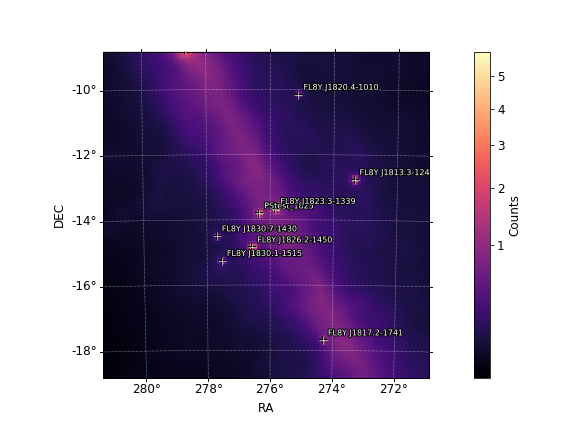

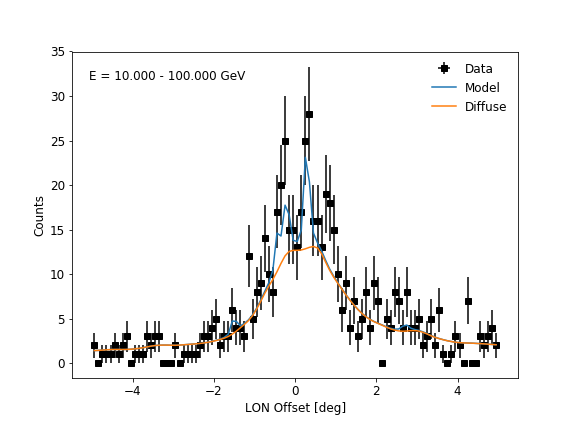

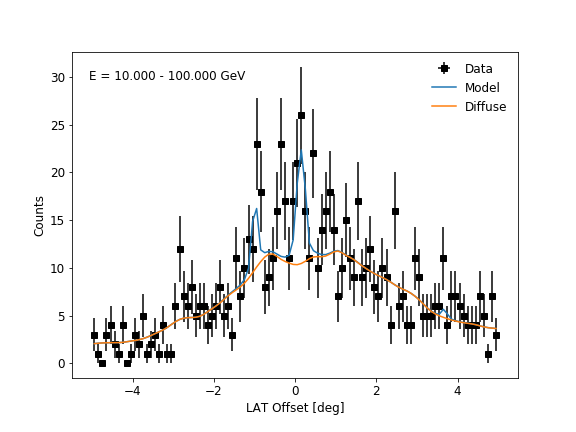

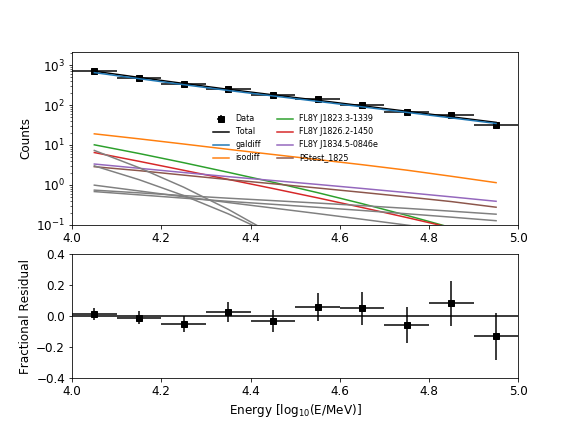

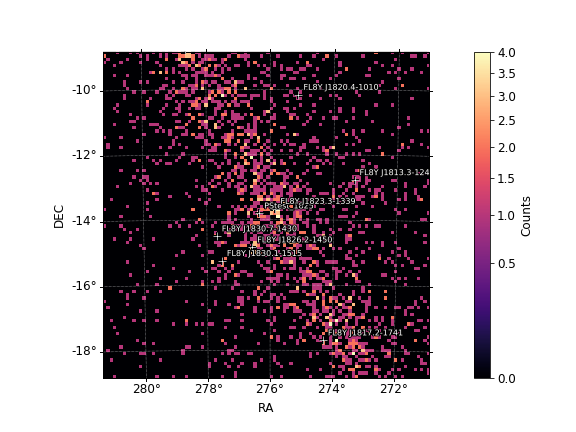

In [32]:
for png in pngs:
    my_image = Image(png)
    display(my_image)

In [36]:
pngsPL8Y = glob('data/fitPL8Y*.png')

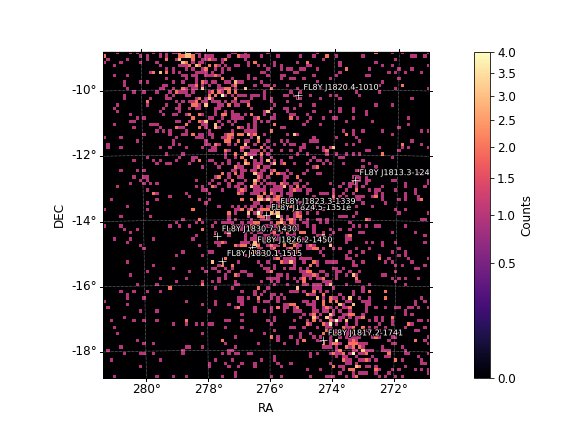

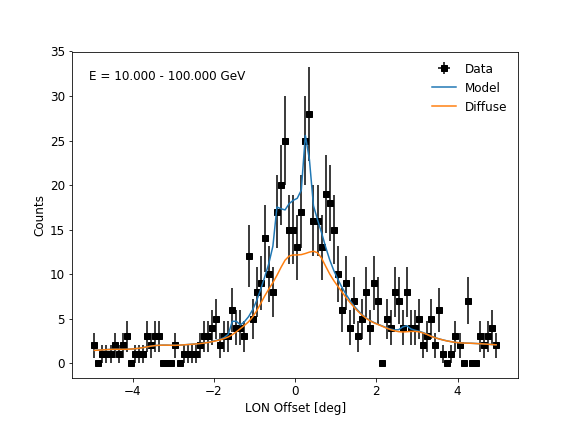

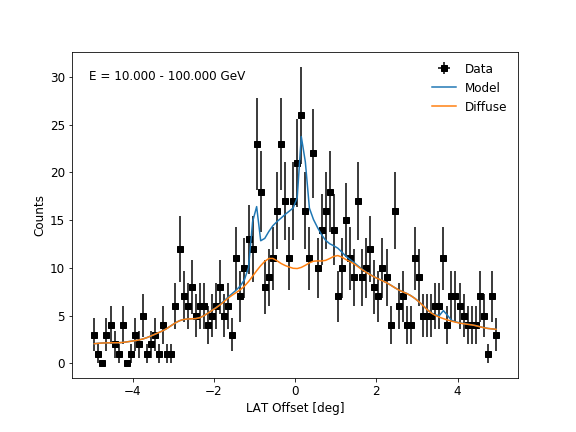

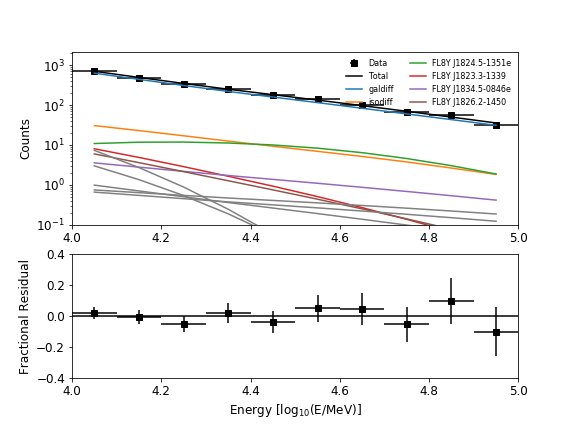

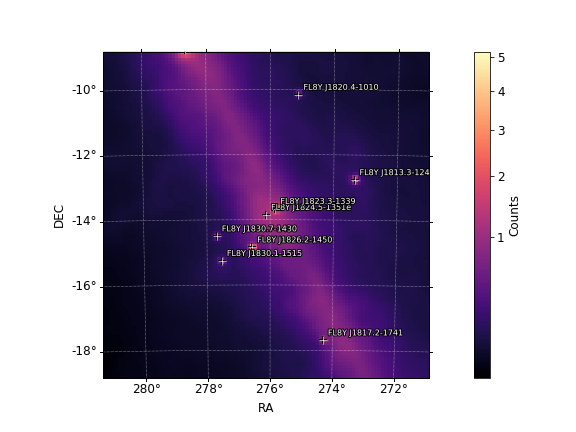

In [37]:
for png in pngsPL8Y:
    my_image = Image(png)
    display(my_image)

In [39]:
print(gta.config['extension'])

{'free_radius': None, 'save_model_map': False, 'width_max': 1.0, 'psf_scale_fn': None, 'width_min': 0.01, 'make_plots': False, 'free_background': False, 'fit_position': False, 'update': False, 'width': [], 'fix_shape': False, 'width_nstep': 21, 'write_fits': True, 'sqrt_ts_threshold': None, 'spatial_model': 'RadialGaussian', 'fit_ebin': False, 'make_tsmap': True, 'write_npy': True}


We adjusted the position for the point source and may need to fit the position for the extended source using the fit_position argument.

In [47]:
ext_RadialDisk = gta.extension('PStest_1825',spatial_model = 'RadialDisk', fit_position = True, write_npy=True, write_fits=True)

2019-06-03 15:48:33 INFO    GTAnalysis.extension(): Running extension fit for PStest_1825
2019-06-03 15:48:33 ERROR   GTAnalysis._fit_optimizer(): Likelihood optimization failed.
Traceback (most recent call last):
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermipy/gtanalysis.py", line 2856, in _fit_optimizer
    self.like.fit(**kw)
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermitools/SummedLikelihood.py", line 95, in fit
    optObject=optObject, numericDerivs=numericDerivs)
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermitools/SummedLikelihood.py", line 196, in _errors
    myOpt.find_min(verbosity, tol, self.tolType)
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermitools/pyLikelihood.py", line 4110, in find_min
    return _pyLikelihood.Minuit_find_min(self, *args)
RuntimeError: Attempt to set the value outside of existing bounds.
2019-06-03 15:48:33 ERROR   GTAnalysis._fit_optimizer(): Likelihood optimization faile

2019-06-03 15:48:39 ERROR   GTAnalysis._fit_optimizer(): Likelihood optimization failed.
Traceback (most recent call last):
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermipy/gtanalysis.py", line 2856, in _fit_optimizer
    self.like.fit(**kw)
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermitools/SummedLikelihood.py", line 95, in fit
    optObject=optObject, numericDerivs=numericDerivs)
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermitools/SummedLikelihood.py", line 196, in _errors
    myOpt.find_min(verbosity, tol, self.tolType)
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermitools/pyLikelihood.py", line 4110, in find_min
    return _pyLikelihood.Minuit_find_min(self, *args)
RuntimeError: Attempt to set the value outside of existing bounds.
2019-06-03 15:48:40 ERROR   GTAnalysis._fit_optimizer(): Likelihood optimization failed.
Traceback (most recent call last):
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-

2019-06-03 15:48:44 ERROR   GTAnalysis._fit_optimizer(): Likelihood optimization failed.
Traceback (most recent call last):
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermipy/gtanalysis.py", line 2856, in _fit_optimizer
    self.like.fit(**kw)
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermitools/SummedLikelihood.py", line 95, in fit
    optObject=optObject, numericDerivs=numericDerivs)
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermitools/SummedLikelihood.py", line 196, in _errors
    myOpt.find_min(verbosity, tol, self.tolType)
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermitools/pyLikelihood.py", line 4110, in find_min
    return _pyLikelihood.Minuit_find_min(self, *args)
RuntimeError: Attempt to set the value outside of existing bounds.
2019-06-03 15:48:44 ERROR   GTAnalysis._fit_optimizer(): Likelihood optimization failed.
Traceback (most recent call last):
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-

2019-06-03 15:49:23 ERROR   GTAnalysis._fit_optimizer(): Likelihood optimization failed.
Traceback (most recent call last):
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermipy/gtanalysis.py", line 2856, in _fit_optimizer
    self.like.fit(**kw)
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermitools/SummedLikelihood.py", line 95, in fit
    optObject=optObject, numericDerivs=numericDerivs)
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermitools/SummedLikelihood.py", line 196, in _errors
    myOpt.find_min(verbosity, tol, self.tolType)
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermitools/pyLikelihood.py", line 4110, in find_min
    return _pyLikelihood.Minuit_find_min(self, *args)
RuntimeError: Attempt to set the value outside of existing bounds.
2019-06-03 15:49:23 ERROR   GTAnalysis._fit_optimizer(): Likelihood optimization failed.
Traceback (most recent call last):
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-

2019-06-03 15:49:29 ERROR   GTAnalysis._fit_optimizer(): Likelihood optimization failed.
Traceback (most recent call last):
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermipy/gtanalysis.py", line 2856, in _fit_optimizer
    self.like.fit(**kw)
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermitools/SummedLikelihood.py", line 95, in fit
    optObject=optObject, numericDerivs=numericDerivs)
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermitools/SummedLikelihood.py", line 196, in _errors
    myOpt.find_min(verbosity, tol, self.tolType)
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermitools/pyLikelihood.py", line 4110, in find_min
    return _pyLikelihood.Minuit_find_min(self, *args)
RuntimeError: Attempt to set the value outside of existing bounds.
2019-06-03 15:49:29 ERROR   GTAnalysis._fit_optimizer(): Likelihood optimization failed.
Traceback (most recent call last):
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-

2019-06-03 15:49:38 ERROR   GTAnalysis._fit_optimizer(): Likelihood optimization failed.
Traceback (most recent call last):
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermipy/gtanalysis.py", line 2856, in _fit_optimizer
    self.like.fit(**kw)
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermitools/SummedLikelihood.py", line 95, in fit
    optObject=optObject, numericDerivs=numericDerivs)
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermitools/SummedLikelihood.py", line 196, in _errors
    myOpt.find_min(verbosity, tol, self.tolType)
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermitools/pyLikelihood.py", line 4110, in find_min
    return _pyLikelihood.Minuit_find_min(self, *args)
RuntimeError: Attempt to set the value outside of existing bounds.
2019-06-03 15:49:38 ERROR   GTAnalysis._fit_optimizer(): Likelihood optimization failed.
Traceback (most recent call last):
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-

2019-06-03 15:50:29 ERROR   GTAnalysis._fit_optimizer(): Likelihood optimization failed.
Traceback (most recent call last):
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermipy/gtanalysis.py", line 2856, in _fit_optimizer
    self.like.fit(**kw)
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermitools/SummedLikelihood.py", line 95, in fit
    optObject=optObject, numericDerivs=numericDerivs)
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermitools/SummedLikelihood.py", line 196, in _errors
    myOpt.find_min(verbosity, tol, self.tolType)
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermitools/pyLikelihood.py", line 4110, in find_min
    return _pyLikelihood.Minuit_find_min(self, *args)
RuntimeError: Attempt to set the value outside of existing bounds.
2019-06-03 15:50:29 ERROR   GTAnalysis._fit_optimizer(): Likelihood optimization failed.
Traceback (most recent call last):
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-

2019-06-03 15:50:34 ERROR   GTAnalysis._fit_optimizer(): Likelihood optimization failed.
Traceback (most recent call last):
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermipy/gtanalysis.py", line 2856, in _fit_optimizer
    self.like.fit(**kw)
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermitools/SummedLikelihood.py", line 95, in fit
    optObject=optObject, numericDerivs=numericDerivs)
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermitools/SummedLikelihood.py", line 196, in _errors
    myOpt.find_min(verbosity, tol, self.tolType)
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermitools/pyLikelihood.py", line 4110, in find_min
    return _pyLikelihood.Minuit_find_min(self, *args)
RuntimeError: Attempt to set the value outside of existing bounds.
2019-06-03 15:50:36 ERROR   GTAnalysis._fit_optimizer(): Likelihood optimization failed.
Traceback (most recent call last):
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-

2019-06-03 15:50:40 ERROR   GTAnalysis._fit_optimizer(): Likelihood optimization failed.
Traceback (most recent call last):
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermipy/gtanalysis.py", line 2856, in _fit_optimizer
    self.like.fit(**kw)
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermitools/SummedLikelihood.py", line 95, in fit
    optObject=optObject, numericDerivs=numericDerivs)
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermitools/SummedLikelihood.py", line 196, in _errors
    myOpt.find_min(verbosity, tol, self.tolType)
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermitools/pyLikelihood.py", line 4110, in find_min
    return _pyLikelihood.Minuit_find_min(self, *args)
RuntimeError: Attempt to set the value outside of existing bounds.
2019-06-03 15:50:40 ERROR   GTAnalysis._fit_optimizer(): Likelihood optimization failed.
Traceback (most recent call last):
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-

2019-06-03 15:50:44 ERROR   GTAnalysis._fit_optimizer(): Likelihood optimization failed.
Traceback (most recent call last):
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermipy/gtanalysis.py", line 2856, in _fit_optimizer
    self.like.fit(**kw)
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermitools/SummedLikelihood.py", line 95, in fit
    optObject=optObject, numericDerivs=numericDerivs)
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermitools/SummedLikelihood.py", line 196, in _errors
    myOpt.find_min(verbosity, tol, self.tolType)
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermitools/pyLikelihood.py", line 4110, in find_min
    return _pyLikelihood.Minuit_find_min(self, *args)
RuntimeError: Attempt to set the value outside of existing bounds.
2019-06-03 15:50:46 ERROR   GTAnalysis._fit_optimizer(): Likelihood optimization failed.
Traceback (most recent call last):
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-

2019-06-03 15:51:29 ERROR   GTAnalysis._fit_optimizer(): Likelihood optimization failed.
Traceback (most recent call last):
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermipy/gtanalysis.py", line 2856, in _fit_optimizer
    self.like.fit(**kw)
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermitools/SummedLikelihood.py", line 95, in fit
    optObject=optObject, numericDerivs=numericDerivs)
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermitools/SummedLikelihood.py", line 196, in _errors
    myOpt.find_min(verbosity, tol, self.tolType)
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermitools/pyLikelihood.py", line 4110, in find_min
    return _pyLikelihood.Minuit_find_min(self, *args)
RuntimeError: Attempt to set the value outside of existing bounds.
2019-06-03 15:51:31 ERROR   GTAnalysis._fit_optimizer(): Likelihood optimization failed.
Traceback (most recent call last):
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-

2019-06-03 15:51:32 ERROR   GTAnalysis._fit_optimizer(): Likelihood optimization failed.
Traceback (most recent call last):
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermipy/gtanalysis.py", line 2856, in _fit_optimizer
    self.like.fit(**kw)
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermitools/SummedLikelihood.py", line 95, in fit
    optObject=optObject, numericDerivs=numericDerivs)
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermitools/SummedLikelihood.py", line 196, in _errors
    myOpt.find_min(verbosity, tol, self.tolType)
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermitools/pyLikelihood.py", line 4110, in find_min
    return _pyLikelihood.Minuit_find_min(self, *args)
RuntimeError: Attempt to set the value outside of existing bounds.
2019-06-03 15:51:33 ERROR   GTAnalysis._fit_optimizer(): Likelihood optimization failed.
Traceback (most recent call last):
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-

2019-06-03 15:51:45 ERROR   GTAnalysis._fit_optimizer(): Likelihood optimization failed.
Traceback (most recent call last):
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermipy/gtanalysis.py", line 2856, in _fit_optimizer
    self.like.fit(**kw)
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermitools/SummedLikelihood.py", line 95, in fit
    optObject=optObject, numericDerivs=numericDerivs)
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermitools/SummedLikelihood.py", line 196, in _errors
    myOpt.find_min(verbosity, tol, self.tolType)
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermitools/pyLikelihood.py", line 4110, in find_min
    return _pyLikelihood.Minuit_find_min(self, *args)
RuntimeError: Attempt to set the value outside of existing bounds.
2019-06-03 15:51:45 ERROR   GTAnalysis._fit_optimizer(): Likelihood optimization failed.
Traceback (most recent call last):
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-

2019-06-03 15:52:27 ERROR   GTAnalysis._fit_optimizer(): Likelihood optimization failed.
Traceback (most recent call last):
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermipy/gtanalysis.py", line 2856, in _fit_optimizer
    self.like.fit(**kw)
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermitools/SummedLikelihood.py", line 95, in fit
    optObject=optObject, numericDerivs=numericDerivs)
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermitools/SummedLikelihood.py", line 196, in _errors
    myOpt.find_min(verbosity, tol, self.tolType)
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermitools/pyLikelihood.py", line 4110, in find_min
    return _pyLikelihood.Minuit_find_min(self, *args)
RuntimeError: Attempt to set the value outside of existing bounds.
2019-06-03 15:52:27 ERROR   GTAnalysis._fit_optimizer(): Likelihood optimization failed.
Traceback (most recent call last):
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-

2019-06-03 15:52:29 ERROR   GTAnalysis._fit_optimizer(): Likelihood optimization failed.
Traceback (most recent call last):
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermipy/gtanalysis.py", line 2856, in _fit_optimizer
    self.like.fit(**kw)
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermitools/SummedLikelihood.py", line 95, in fit
    optObject=optObject, numericDerivs=numericDerivs)
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermitools/SummedLikelihood.py", line 196, in _errors
    myOpt.find_min(verbosity, tol, self.tolType)
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermitools/pyLikelihood.py", line 4110, in find_min
    return _pyLikelihood.Minuit_find_min(self, *args)
RuntimeError: Attempt to set the value outside of existing bounds.
2019-06-03 15:52:29 ERROR   GTAnalysis._fit_optimizer(): Likelihood optimization failed.
Traceback (most recent call last):
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-

2019-06-03 15:52:30 ERROR   GTAnalysis._fit_optimizer(): Likelihood optimization failed.
Traceback (most recent call last):
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermipy/gtanalysis.py", line 2856, in _fit_optimizer
    self.like.fit(**kw)
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermitools/SummedLikelihood.py", line 95, in fit
    optObject=optObject, numericDerivs=numericDerivs)
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermitools/SummedLikelihood.py", line 196, in _errors
    myOpt.find_min(verbosity, tol, self.tolType)
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermitools/pyLikelihood.py", line 4110, in find_min
    return _pyLikelihood.Minuit_find_min(self, *args)
RuntimeError: Attempt to set the value outside of existing bounds.
2019-06-03 15:52:32 ERROR   GTAnalysis._fit_optimizer(): Likelihood optimization failed.
Traceback (most recent call last):
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-

2019-06-03 15:52:35 ERROR   GTAnalysis._fit_optimizer(): Likelihood optimization failed.
Traceback (most recent call last):
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermipy/gtanalysis.py", line 2856, in _fit_optimizer
    self.like.fit(**kw)
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermitools/SummedLikelihood.py", line 95, in fit
    optObject=optObject, numericDerivs=numericDerivs)
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermitools/SummedLikelihood.py", line 196, in _errors
    myOpt.find_min(verbosity, tol, self.tolType)
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermitools/pyLikelihood.py", line 4110, in find_min
    return _pyLikelihood.Minuit_find_min(self, *args)
RuntimeError: Attempt to set the value outside of existing bounds.
2019-06-03 15:52:37 ERROR   GTAnalysis._fit_optimizer(): Likelihood optimization failed.
Traceback (most recent call last):
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-

2019-06-03 15:52:45 ERROR   GTAnalysis._fit_optimizer(): Likelihood optimization failed.
Traceback (most recent call last):
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermipy/gtanalysis.py", line 2856, in _fit_optimizer
    self.like.fit(**kw)
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermitools/SummedLikelihood.py", line 95, in fit
    optObject=optObject, numericDerivs=numericDerivs)
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermitools/SummedLikelihood.py", line 196, in _errors
    myOpt.find_min(verbosity, tol, self.tolType)
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermitools/pyLikelihood.py", line 4110, in find_min
    return _pyLikelihood.Minuit_find_min(self, *args)
RuntimeError: Attempt to set the value outside of existing bounds.
2019-06-03 15:52:45 ERROR   GTAnalysis._fit_optimizer(): Likelihood optimization failed.
Traceback (most recent call last):
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-

Let's try that while freeing nearby sources and the background normalization.

In [48]:
ext_RadialDisk_free = gta.extension('PStest_1825', spatial_model = 'RadialDisk', fit_position = True, free_radius=3.0, free_background = True)
print 'Fixed Sources: %f +/- %f'%(ext_RadialDisk['ext'],ext_RadialDisk['ext_err'])
print 'Free Sources:  %f +/- %f'%(ext_RadialDisk_free['ext'],ext_RadialDisk_free['ext_err'])

2019-06-03 15:58:47 INFO    GTAnalysis.extension(): Running extension fit for PStest_1825
2019-06-03 15:58:52 ERROR   GTAnalysis._fit_optimizer(): Likelihood optimization failed.
Traceback (most recent call last):
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermipy/gtanalysis.py", line 2856, in _fit_optimizer
    self.like.fit(**kw)
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermitools/SummedLikelihood.py", line 95, in fit
    optObject=optObject, numericDerivs=numericDerivs)
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermitools/SummedLikelihood.py", line 196, in _errors
    myOpt.find_min(verbosity, tol, self.tolType)
  File "/opt/anaconda/envs/fermi/lib/python2.7/site-packages/fermitools/pyLikelihood.py", line 4110, in find_min
    return _pyLikelihood.Minuit_find_min(self, *args)
RuntimeError: Attempt to set the value outside of existing bounds.
2019-06-03 15:58:52 ERROR   GTAnalysis._fit_optimizer(): Likelihood optimization faile

2019-06-03 16:03:08 INFO    GTAnalysis._extension(): Best-fit extension: 0.0173 + 0.0000 - 0.0000
2019-06-03 16:03:08 INFO    GTAnalysis._extension(): TS_ext:        -5.538
2019-06-03 16:03:08 INFO    GTAnalysis._extension(): Extension UL: 0.0173
2019-06-03 16:03:08 INFO    GTAnalysis._extension(): LogLike:   -12811.690 DeltaLogLike:       -5.468
2019-06-03 16:03:08 INFO    GTAnalysis._extension(): Position:
(  ra, dec) = (  277.1709 +/-   0.2244,  -14.3187 +/-   0.2244)
(glon,glat) = (   17.6244 +/-   0.2244,   -1.5641 +/-   0.2244)
offset =   0.9504 r68 =   0.3403 r95 =   0.5492 r99 =   0.6810
2019-06-03 16:03:08 INFO    GTAnalysis.extension(): Finished extension fit.
2019-06-03 16:03:08 INFO    GTAnalysis.extension(): Execution time: 261.22 s


Fixed Sources: 0.048057 +/- 0.002157
Free Sources:  0.017260 +/- 0.000000


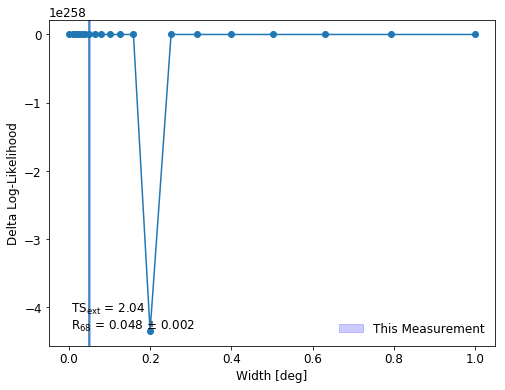

In [55]:
matplotlib.interactive(True)

plt.figure(figsize=(8,6))
plt.plot(ext_RadialDisk['width'],ext_RadialDisk['dloglike'],marker='o')
plt.gca().set_xlabel('Width [deg]')
plt.gca().set_ylabel('Delta Log-Likelihood')
plt.gca().axvline(ext_RadialDisk['ext'])
plt.gca().axvspan(ext_RadialDisk['ext']-ext_RadialDisk['ext_err_lo'],ext_RadialDisk['ext']+ext_RadialDisk['ext_err_hi'],
                      alpha=0.2,label='This Measurement',color='b')

#plt.gca().axvline(0.5,color='k')
#plt.gca().axvspan(0.5-0.01,1.9+0.01,alpha=0.2,label='Ref',color='k')
#plt.gca().set_ylim(-10,10)
#plt.gca().set_xlim(0.005,0.20)

plt.annotate('TS$_{\mathrm{ext}}$ = %.2f\nR$_{68}$ = %.3f $\pm$ %.3f'%
            (ext_RadialDisk['ts_ext'],ext_RadialDisk['ext'],ext_RadialDisk['ext_err']),xy=(0.05,0.05),xycoords='axes fraction')
plt.gca().legend(frameon=False)

## You can also make a TS map 

This is a map that puts a tentative source at every location and calculates the likelihood of it existing.

In [56]:
tsmap = gta.tsmap('PStest_1825',model={'SpatialModel' : 'PointSource', 'Index' : 2.0})

2019-06-03 16:39:36 INFO    GTAnalysis.tsmap(): Generating TS map
2019-06-03 16:40:03 INFO    GTAnalysis._make_tsmap_fast(): Fitting test source.
2019-06-03 16:40:09 INFO    GTAnalysis.tsmap(): Finished TS map
2019-06-03 16:40:09 INFO    GTAnalysis.tsmap(): Execution time: 33.33 s


In [58]:
from fermipy.plotting import ROIPlotter

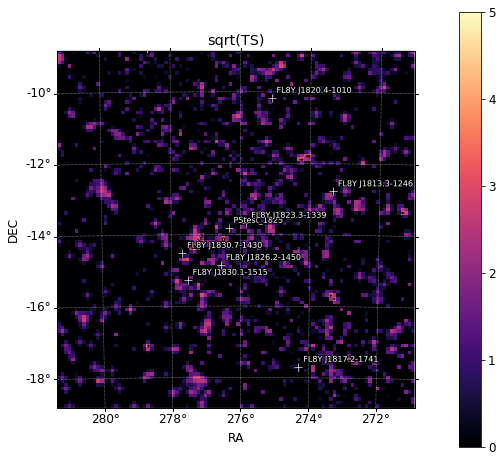

In [59]:
o = tsmap

fig = plt.figure(figsize=(8,8))
ROIPlotter(o['sqrt_ts'],roi=gta.roi).plot(vmin=0,vmax=5,levels=[3,5,7,9],subplot=111,cmap='magma')
plt.gca().set_title('sqrt(TS)')
plt.show()

## Make an SED

There are many advanced functions like SEDs and lightcurves (see the documentation).  We'll make and SED.

In [60]:
sed = gta.sed('PStest_1825')

2019-06-03 16:44:20 INFO    GTAnalysis.sed(): Computing SED for PStest_1825
2019-06-03 16:44:21 INFO    GTAnalysis._make_sed(): Fitting SED
2019-06-03 16:44:22 INFO    GTAnalysis.sed(): Finished SED
2019-06-03 16:44:23 INFO    GTAnalysis.sed(): Execution time: 2.20 s


In [61]:
source = gta.roi.get_source_by_name('PStest_1825')

In [66]:
print(source)

Name           : PStest_1825
Associations   : ['PStest_1825']
RA/DEC         :    276.346/   -13.806
GLON/GLAT      :     17.706/    -0.617
TS             : 11.00
Npred          : 11.96
Flux           : 2.678e-10 +/- 1.16e-10
EnergyFlux     : 6.526e-06 +/- 2.82e-06
SpatialModel   : RadialDisk
SpectrumType   : PowerLaw
Spectral Parameters
Prefactor      :  4.472e-12 +/-   9.86e-12
Index          :     -2.134 +/-        nan
Scale          :       1000 +/-        nan


In [76]:
gta.sed?

In [62]:
E = np.array(source['model_flux']['energies'])
dnde = np.array(source['model_flux']['dnde'])
dnde_hi = np.array(source['model_flux']['dnde_hi'])
dnde_lo = np.array(source['model_flux']['dnde_lo'])

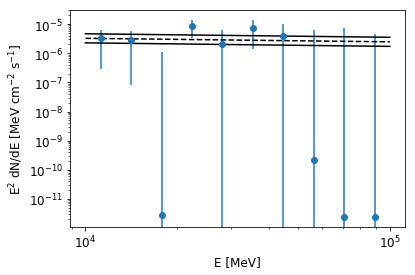

In [63]:
plt.loglog(E, (E**2)*dnde, 'k--')
plt.loglog(E, (E**2)*dnde_hi, 'k')
plt.loglog(E, (E**2)*dnde_lo, 'k')
plt.errorbar(np.array(sed['e_ctr']),
             sed['e2dnde'], 
             yerr=sed['e2dnde_err'], fmt ='o')
plt.xlabel('E [MeV]')
plt.ylabel(r'E$^{2}$ dN/dE [MeV cm$^{-2}$ s$^{-1}$]')
plt.show()

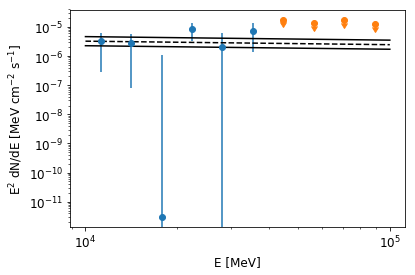

In [64]:
plt.loglog(E, (E**2)*dnde, 'k--')
plt.loglog(E, (E**2)*dnde_hi, 'k')
plt.loglog(E, (E**2)*dnde_lo, 'k')
plt.errorbar(sed['e_ctr'][:-4],
             sed['e2dnde'][:-4], 
             yerr=sed['e2dnde_err'][:-4], fmt ='o')
plt.errorbar(np.array(sed['e_ctr'][-4:]),
         sed['e2dnde_ul95'][-4:], yerr=0.2*sed['e2dnde_ul95'][-4:], 
             fmt='o', uplims=True)
plt.xlabel('E [MeV]')
plt.ylabel(r'E$^{2}$ dN/dE [MeV cm$^{-2}$ s$^{-1}$]')
plt.show()

2019-06-03 16:46:10 INFO    GTBinnedAnalysis.write_xml(): Writing /data/fermi-summer-school/Extended_Analysis/data/fit_extRadDisk_sed_00.xml...
2019-06-03 16:46:10 INFO    GTBinnedAnalysis.write_xml(): Writing /data/fermi-summer-school/Extended_Analysis/data/fit_extRadDisk_sed_01.xml...
2019-06-03 16:46:11 INFO    GTBinnedAnalysis.write_xml(): Writing /data/fermi-summer-school/Extended_Analysis/data/fit_extRadDisk_sed_02.xml...
2019-06-03 16:46:11 INFO    GTBinnedAnalysis.write_xml(): Writing /data/fermi-summer-school/Extended_Analysis/data/fit_extRadDisk_sed_03.xml...
2019-06-03 16:46:11 INFO    GTAnalysis.write_fits(): Writing /data/fermi-summer-school/Extended_Analysis/data/fit_extRadDisk_sed.fits...
2019-06-03 16:46:29 INFO    GTAnalysis.write_roi(): Writing /data/fermi-summer-school/Extended_Analysis/data/fit_extRadDisk_sed.npy...


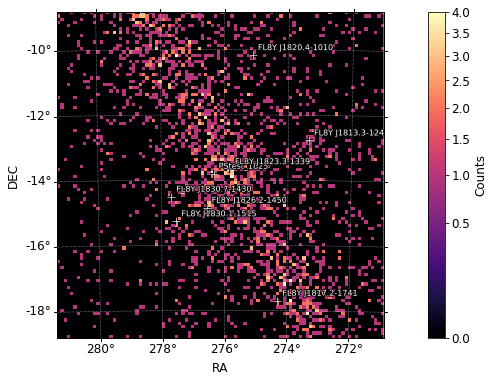

In [65]:
gta.write_roi('fit_extRadDisk_sed',make_plots=True)